### <center> In this notebook the climatologies of all datasets and all variables is computed

Since there is a lot of different datasets and variables this notebook is separated in the following sections:
* S2S Reforecasts
* GLORYS12V1 Mercator Ocean Reanalysis
* Sea level from satellite altimetry
* Sea surface temperature from **** satellite product
* ERA5 ECMWF Atmospheric Reanalysis

For each section the annual cycle will be computed on a daily basis. The methodology consist in computing the daily average over a long period (>20 years), then smooth the noisy daily average and store it on disk. This is computed for each variable, position along the coast/equator, ensamble member and leadtime (in case of S2S forecast). In addition an intraseasonal baseline will be computed for the future calculation of intraseasonal anomalies. The baseline is built on three steps: (i) compute the monthly means of the data, (ii) center the monthly values on the 15th of each month and (iii) upsample the baseline to daily frequency using cubic splines. The boundaries of the dataset (first and last 15 days) are removed from the dataset. 

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
from utils import *
import tqdm

---
#### <center> S2S REFORECASTS

In [50]:
timevector = xr.date_range('2000-01-07','2022-07-04', calendar='noleap')

In [21]:
tropical   = xr.open_dataset('data/HOVMOLLERS/S2S_hovmoller_tropical_2000-2022.nc', decode_timedelta=False)
coastnorth = xr.open_dataset('data/HOVMOLLERS/S2S_hovmoller_coastnorth_2000-2022.nc', decode_timedelta=False)
coastsouth = xr.open_dataset('data/HOVMOLLERS/S2S_hovmoller_coastsouth_2000-2022.nc', decode_timedelta=False)

In [202]:
# Tropical climatology
x = tropical.copy().sel(inittime=slice('2000','2020'))
x = x.drop_duplicates('inittime')
x = x.convert_calendar('noleap', dim='inittime')
x = x.reindex({'inittime':timevector})
tropical_climatology = []
for lead in tqdm.trange(46):
    # shift the time vector based on the leadtime value
    y = x.sel(leadtime=lead)
    y.coords['inittime'] = y.inittime+pd.Timedelta(days=lead)
    clim = compute_climatology(y, 'inittime')
    clim = clim.interpolate_na('dayofyear')
    tropical_climatology.append(clim)
print('join')
tropical_climatology = xr.concat(tropical_climatology,'leadtime')

100%|██████████| 46/46 [10:15<00:00, 13.37s/it]


join


In [203]:
# Northern hemisphere climatology
x = coastnorth.copy().sel(inittime=slice('2000','2020'))
x = x.drop_duplicates('inittime')
x = x.convert_calendar('noleap', dim='inittime')
x = x.reindex({'inittime':timevector})
coastnorth_climatology = []
for lead in tqdm.trange(46):
    # shift the time vector based on the leadtime value
    y = x.sel(leadtime=lead)
    y.coords['inittime'] = y.inittime+pd.Timedelta(days=lead)
    clim = compute_climatology(y, 'inittime')
    clim = clim.interpolate_na('dayofyear')
    coastnorth_climatology.append(clim)
print('join')
coastnorth_climatology = xr.concat(coastnorth_climatology,'leadtime')

100%|██████████| 46/46 [04:20<00:00,  5.66s/it]


join


In [204]:
# Southern hemisphere climatology
x = coastsouth.copy().sel(inittime=slice('2000','2020'))
x = x.drop_duplicates('inittime')
x = x.convert_calendar('noleap', dim='inittime')
x = x.reindex({'inittime':timevector})
coastsouth_climatology = []
for lead in tqdm.trange(46):
    # shift the time vector based on the leadtime value
    y = x.sel(leadtime=lead)
    y.coords['inittime'] = y.inittime+pd.Timedelta(days=lead)
    clim = compute_climatology(y, 'inittime')
    clim = clim.interpolate_na('dayofyear')
    coastsouth_climatology.append(clim)
print('join')
coastsouth_climatology = xr.concat(coastsouth_climatology,'leadtime')

100%|██████████| 46/46 [04:25<00:00,  5.78s/it]


join


Text(0.5, 1.0, '2000-2020 Climatology of S2S dataset for: -30.0°S')

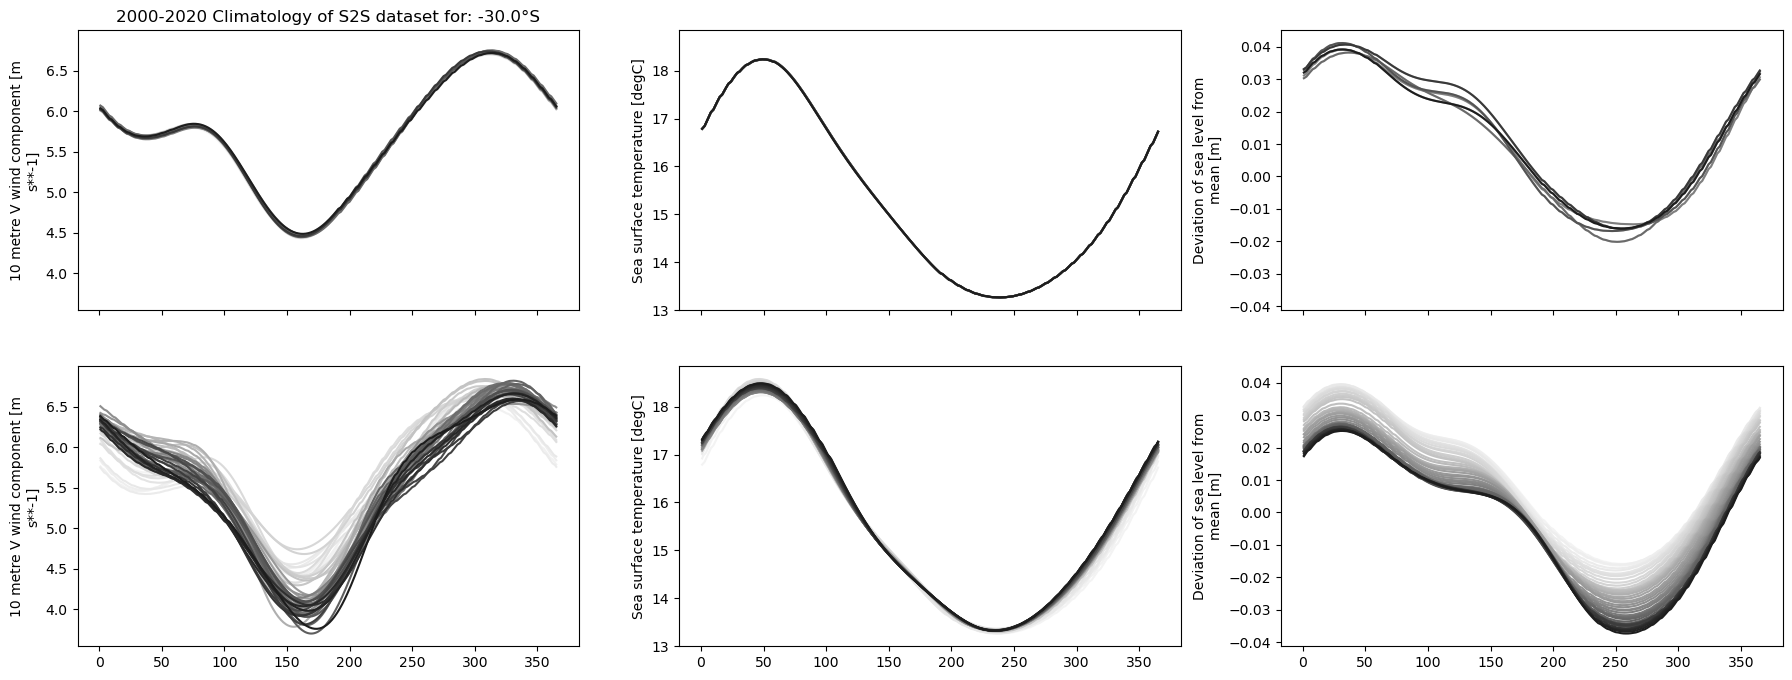

In [226]:
x = coastsouth_climatology.isel(distance=27)
fig, ax = plt.subplots(2,3, sharex=True, sharey='col', figsize=(22,8), facecolor='w', dpi=100)

colors = plt.cm.Greys(np.linspace(0.1,0.9,11))
# plot climatology for different ensamble members
for member in range(11):
    x['10v'].isel(leadtime=0, member=member).plot(ax=ax[0,0], label=f'Ensamble member {member}', color=colors[member])
    x['sst'].isel(leadtime=0, member=member).plot(ax=ax[0,1], color=colors[member])
    (x['zos']).isel(leadtime=0, member=member).plot(ax=ax[0,2], color=colors[member])
    ax[0,0].set_title('');ax[0,1].set_title('');ax[0,2].set_title('')
    ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');ax[0,2].set_xlabel('')
    
colors = plt.cm.Greys(np.linspace(0.1,0.9,46))
# plot climatology for one member but different leadtimes
for lead in range(46):
    x['10v'].isel(leadtime=lead, member=0).plot(ax=ax[1,0], label=f'Leadtime {lead}', color=colors[lead])
    x['sst'].isel(leadtime=lead, member=0).plot(ax=ax[1,1], color=colors[lead])
    (x['zos']).isel(leadtime=lead, member=0).plot(ax=ax[1,2], color=colors[lead])
    ax[1,0].set_title('');ax[1,1].set_title('');ax[1,2].set_title('')
    ax[1,0].set_xlabel('');ax[1,1].set_xlabel('');ax[1,2].set_xlabel('')

ax[0,0].set_title('2000-2020 Climatology of S2S dataset for: {}°S'.format(x.lat.item()))

Last figure show some examples of the computed climatologies. For instance the first row and column show the meridional wind speed climatology and the dispersion along the ensamble members (very low). The second row show the leadtime dependant climatology, where it can be seen there is a similar behavior along leadtimes but with different magnitudes, specially in the meridional wind and in the sea level. 

In [231]:
# Some basic metadata
coastsouth_climatology.dayofyear.attrs = {'standard_name':'Julian day'}
coastnorth_climatology.dayofyear.attrs = {'standard_name':'Julian day'}
tropical_climatology.dayofyear.attrs   = {'standard_name':'Julian day'}

coastsouth_climatology.attrs['name'] = 'Coastal Southern Hemisphere Climatology of S2S reforecasts 2000-2020'
coastnorth_climatology.attrs['name'] = 'Coastal Northern Hemisphere Climatology of S2S reforecasts 2000-2020'
tropical_climatology.attrs['name']   = 'Tropical Climatology of S2S reforecasts 2000-2020'

In [232]:
# # SAVE TO DISK
# tropical_climatology.to_netcdf('data/HOVMOLLERS/CLIMATOLOGIES/S2S_climatology_tropical_2000-2020.nc')
# coastnorth_climatology.to_netcdf('data/HOVMOLLERS/CLIMATOLOGIES/S2S_climatology_coastnorth_2000-2020.nc')
# coastsouth_climatology.to_netcdf('data/HOVMOLLERS/CLIMATOLOGIES/S2S_climatology_coastsouth_2000-2020.nc')

Now that the traditional climatology is done i will compute the intraseasonal baseline

In [269]:
# Tropical baseline
x = tropical.copy()
x = x.drop_duplicates('inittime')
x = x.convert_calendar('noleap', dim='inittime')
x = x.reindex({'inittime':timevector}).interpolate_na('inittime')
tropical_baseline = []
for lead in tqdm.trange(46):
    y = x.sel(leadtime=lead).resample({'inittime':'M'}).mean()
    y.coords['inittime'] = y.inittime+pd.Timedelta(days=15)
    y = y.reindex({'inittime':x.inittime}).interpolate_na(dim='inittime', method='cubic')
    y = y.convert_calendar('gregorian', dim='inittime')
    tropical_baseline.append(y)
tropical_baseline = xr.concat(tropical_baseline, 'leadtime')

In [316]:
# Coastnorth baseline
x = coastnorth.copy()
x = x.drop_duplicates('inittime')
x = x.convert_calendar('noleap', dim='inittime')
x = x.reindex({'inittime':timevector}).interpolate_na('inittime')
coastnorth_baseline = []
for lead in tqdm.trange(46):
    y = x.sel(leadtime=lead).resample({'inittime':'M'}).mean()
    y.coords['inittime'] = y.inittime+pd.Timedelta(days=15)
    y = y.reindex({'inittime':x.inittime}).interpolate_na(dim='inittime', method='cubic')
    y = y.convert_calendar('gregorian', dim='inittime')
    coastnorth_baseline.append(y)
coastnorth_baseline = xr.concat(coastnorth_baseline, 'leadtime')

100%|██████████| 46/46 [02:48<00:00,  3.67s/it]


In [317]:
# Coastsouth baseline
x = coastsouth.copy()
x = x.drop_duplicates('inittime')
x = x.convert_calendar('noleap', dim='inittime')
x = x.reindex({'inittime':timevector}).interpolate_na('inittime')
coastsouth_baseline = []
for lead in tqdm.trange(46):
    y = x.sel(leadtime=lead).resample({'inittime':'M'}).mean()
    y.coords['inittime'] = y.inittime+pd.Timedelta(days=15)
    y = y.reindex({'inittime':x.inittime}).interpolate_na(dim='inittime', method='cubic')
    y = y.convert_calendar('gregorian', dim='inittime')
    coastsouth_baseline.append(y)
coastsouth_baseline = xr.concat(coastsouth_baseline, 'leadtime')

100%|██████████| 46/46 [02:49<00:00,  3.68s/it]


In [325]:
# Some basic metadata
coastsouth_baseline.attrs['name'] = 'Coastal Southern Hemisphere intraseasonal baseline of S2S reforecasts 2000-2020'
coastnorth_baseline.attrs['name'] = 'Coastal Northern Hemisphere intraseasonal baseline of S2S reforecasts 2000-2020'
tropical_baseline.attrs['name']   = 'Tropical intraseasonal baseline of S2S reforecasts 2000-2020'

In [326]:
# SAVE TO DISK
tropical_baseline.dropna('inittime').to_netcdf('data/HOVMOLLERS/INTRASEASONAL_BASELINES/S2S_intraseasonal-baseline_tropical_2000-2022.nc')
coastnorth_baseline.dropna('inittime').to_netcdf('data/HOVMOLLERS/INTRASEASONAL_BASELINES/S2S_intraseasonal-baseline_coastnorth_2000-2022.nc')
coastsouth_baseline.dropna('inittime').to_netcdf('data/HOVMOLLERS/INTRASEASONAL_BASELINES/S2S_intraseasonal-baseline_coastsouth_2000-2022.nc')

---
#### <center> GLORYS12V1 Mercator Ocean Reanalysis